<font size='6'>Titanic dataset</font><br><br>
<font size='6'><b>🚢 Understanding Survival</b></font><br><br>

<font size='4'>Antonio Buzzelli</font><br>
<font size='4'>March 2023</font>

The Titanic disaster remains one of the most infamous shipwrecks in history, with over 1500 lives lost. In this notebook, we will explore and analyze a dataset containing information on passengers who were aboard the ship and build a machine learning model to predict which passengers are likely to have survived the tragedy.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap

## Data

After having installed and imported the necessary libraries, we begin our work by accessing the dataset containing the passengers' data.

In [2]:
df = pd.read_csv('titanic.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


The variables included in the dataset are:
* **PassengerId**: An integer value representing the unique ID of each passenger on board.
* **Survived**: A binary variable indicating whether the passenger survived the sinking of the Titanic or not, with "True" indicating survival and "False" indicating death.
* **Pclass**: An integer variable representing the class of the passenger's ticket, with values 1, 2, or 3 (1 being the highest class).
* **Name**: A string variable representing the name of the passenger.
* **Sex**: A string variable representing the gender of the passenger.
* **Age**: A float variable representing the age of the passenger in years.
* **SibSp**: An integer variable representing the number of siblings or spouses the passenger had on board.
* **Parch**: An integer variable representing the number of parents or children the passenger had on board.
* **Ticket**: A string variable representing the ticket number of the passenger.
* **Fare**: A float variable representing the fare paid by the passenger for their ticket.
* **Cabin**: A string variable representing the cabin number of the passenger, if applicable.
* **Embarked**: A string variable representing the port of embarkation for the passenger, with possible values "S" (Southampton), "C" (Cherbourg), or "Q" (Queenstown).

<!-- ## Exploratory analysis

In order to predict the survival of Titanic's passengers, we will focus our work on the **target variable `Survived`**. Let's begin with an exploratory analysis of the dataset (focused on the target variable) that will provide insights on the need of potential data cleaning and preprocessing operations, and potential interesting correlations. -->

## Transformations, feature engineering, preprocessing

In this first section we are going to explore and process the given dataset and prepare it for modeling. Let's first take a general look at the variables from the structural point-of-view.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


`PassengerId` column is a useless variable in terms of prediction capabilities. We can set it as dataframe index (or drop it) to keep it out of the scope.

In [4]:
df = df.set_index('PassengerId')
# df = df.drop(columns=['PassengerId'])

To give more weight to first class (and vice-versa) `Pclass` values must be inverted.

In [5]:
conditions = [df['Pclass'] == 1, df['Pclass'] == 3]
choices = [3, 1]
df['Pclass'] = np.select(conditions, choices, 2)

Let's assess now the presence of **null values**.
Percentage of null values per variable:

In [6]:
display((df.isnull().sum() / df.shape[0]).round(3).sort_values(ascending=False))

Cabin       0.771
Age         0.199
Embarked    0.002
Survived    0.000
Pclass      0.000
Name        0.000
Sex         0.000
SibSp       0.000
Parch       0.000
Ticket      0.000
Fare        0.000
dtype: float64

A part from a negligeable presence of null values in the `Embarked` variable, we can see that important columns such as `Cabin` and `Age` are full of empty observations. Before proceeding with the model development, we'll have to deal with these inconsistencies.

In [7]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [8]:
display(df['Cabin'].value_counts().head(30))

B96 B98            4
G6                 4
C23 C25 C27        4
C22 C26            3
F33                3
F2                 3
E101               3
D                  3
C78                2
C93                2
E8                 2
D36                2
B77                2
C123               2
E121               2
E44                2
D35                2
C125               2
E67                2
B35                2
B18                2
E24                2
B49                2
C65                2
B20                2
B5                 2
B57 B59 B63 B66    2
C126               2
B51 B53 B55        2
F4                 2
Name: Cabin, dtype: int64

The majority of the cabins in the dataset seem to follow a pattern of a letter followed by a two or three digit number, suggesting that the letter represents the section or deck where the cabin is situated and the number represents the room number. It is reasonable to assume that knowing the section where a passenger's cabin is located would provide valuable information about their likelihood of survival. Therefore, it would be beneficial to clean up the column containing cabin information to extract useful insights.

In [9]:
trans_df = df.copy()

In [10]:
# Splitting Cabin variable into Deck and Room variables
trans_df['CabinData'] = trans_df['Cabin'].isnull().apply(lambda x: not x)
trans_df['Deck'] = trans_df['Cabin'].str.slice(0,1)
trans_df['Room'] = trans_df['Cabin'].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")

In [11]:
trans_df[['Survived', 'CabinData']] = trans_df[['Survived', 'CabinData']].astype(int)

In [12]:
# Label-encoding target variable
trans_df['Female'] = np.where(trans_df['Sex'] == 'female', 1, 0)

# Drop useless variables for modeling
trans_df = trans_df.drop(columns=['Name', 'Ticket', 'Cabin', 'Sex', 'Room'])

In [13]:
# Create one-hot encoding of the categorical variable
df_encoded = pd.get_dummies(trans_df, columns=['Deck', 'Embarked'])

# Impute missing values with KNN imputer
imputer = KNNImputer(n_neighbors=8)
imputed_df = imputer.fit_transform(df_encoded)
imputed_df = pd.DataFrame(imputed_df, columns=df_encoded.columns)

In [14]:
imputed_df

,Survived,Pclass,Age,SibSp,Parch,Fare,CabinData,Female,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Embarked_C,Embarked_Q,Embarked_S
0,0.0,1.0,22.00,1.0,0.0,7.2500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,3.0,38.00,1.0,0.0,71.2833,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,26.00,0.0,0.0,7.9250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,3.0,35.00,1.0,0.0,53.1000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,35.00,0.0,0.0,8.0500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2.0,27.00,0.0,0.0,13.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887,1.0,3.0,19.00,0.0,0.0,30.0000,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
888,0.0,1.0,23.75,1.0,2.0,23.4500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
889,1.0,3.0,26.00,0.0,0.0,30.0000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Exploratory analysis

We have transformed our dataframe by imputing missing values with a KNNImputer algorythm and one-hot encoded categorical variables. Let's now perform an exploratory analysis to look for potential correlations between our target variable and the others.

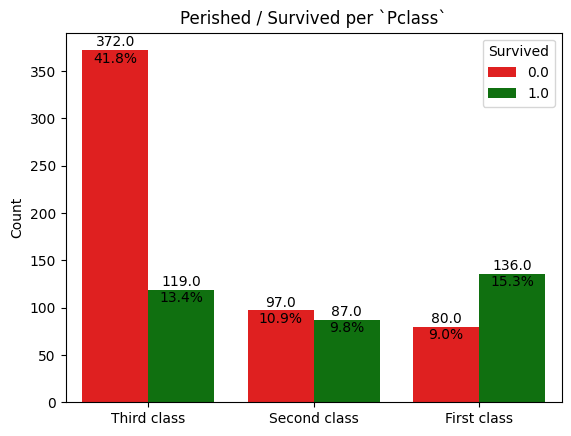

In [15]:
ax = sns.countplot(x="Pclass", data=imputed_df, hue='Survived', palette=['red', 'green'])
ax.set(xlabel='')

for p in ax.patches:
    count = p.get_height()
    percentage = '{:.1f}%'.format(100 * count / len(imputed_df))
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    ax.annotate(f'{count}\n{percentage}', (x, y), ha='center', va='center')
    
plt.xticks([0, 1, 2], ['Third class', 'Second class', 'First class'])
plt.title("Perished / Survived per `Pclass`")
plt.ylabel("Count")
plt.show()

42% of perished people is coming from the third class.

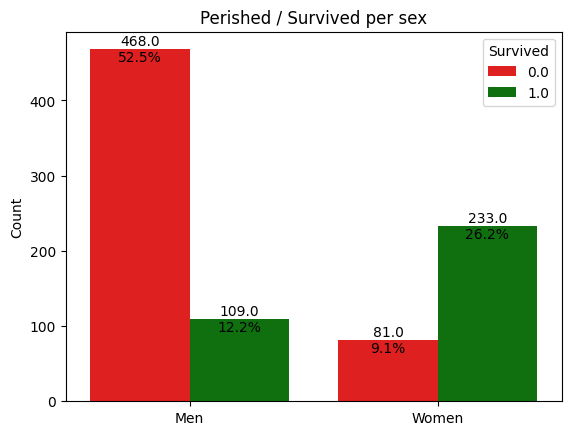

In [16]:
ax = sns.countplot(x="Female", data=imputed_df, hue='Survived', palette=['red', 'green'])
ax.set(xlabel='')

for p in ax.patches:
    count = p.get_height()
    percentage = '{:.1f}%'.format(100 * count / len(imputed_df))
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    ax.annotate(f'{count}\n{percentage}', (x, y), ha='center', va='center')
    
plt.xticks([0, 1], ['Men', 'Women'])
plt.title("Perished / Survived per sex")
plt.ylabel("Count")
plt.show()

The majority of perished people are men, while the majority of survived are women.

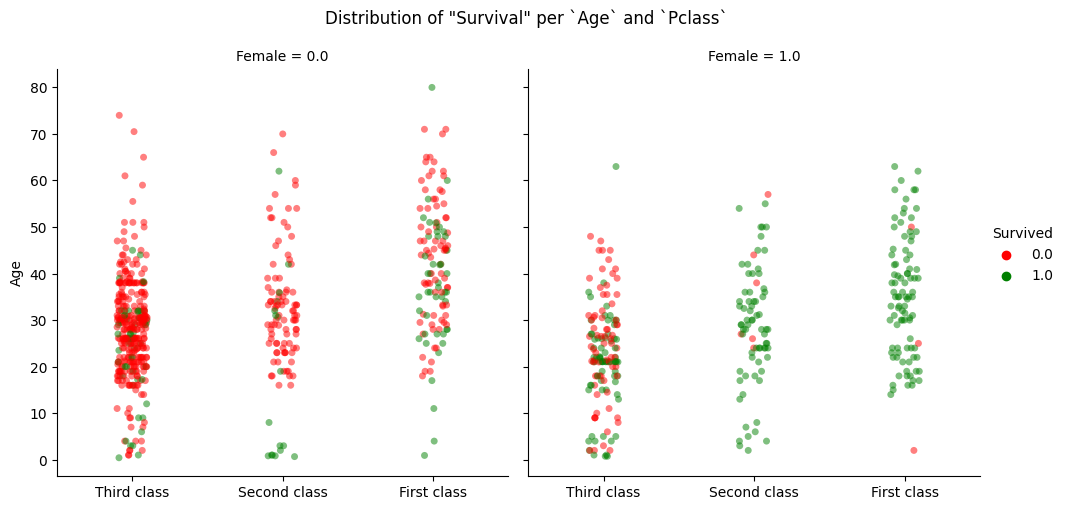

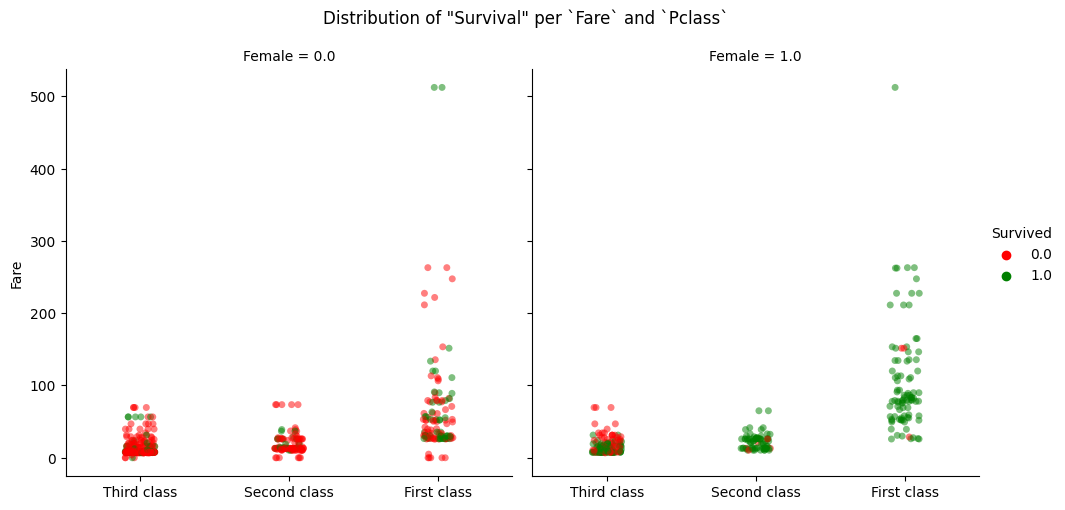

In [17]:
catplot = sns.catplot(data=imputed_df, y="Age", x="Pclass", hue='Survived', col='Female', alpha=0.5, palette=['red', 'green'])
catplot.set(xlabel='')
plt.xticks([0, 1, 2], ['Third class', 'Second class', 'First class'])
catplot.fig.suptitle('Distribution of "Survival" per `Age` and `Pclass`', y=1.05)
plt.show()

catplot = sns.catplot(data=imputed_df, y="Fare", x="Pclass", hue='Survived', col='Female', alpha=0.5, palette=['red', 'green'])
catplot.set(xlabel='')
plt.xticks([0, 1, 2], ['Third class', 'Second class', 'First class'])
catplot.fig.suptitle('Distribution of "Survival" per `Fare` and `Pclass`', y=1.05)
plt.show()

Already from these exploratory visualizations, we can easily see that the majority of survived people are women and people from the top classes. Will this be confirmed by the model?

In [18]:
survived_corr = imputed_df.corr()['Survived'].sort_values(ascending=False)[1:]
display(survived_corr)

Female        0.543351
Pclass        0.338481
CabinData     0.316912
Fare          0.257307
Deck_B        0.175095
Embarked_C    0.168240
Deck_D        0.150716
Deck_E        0.145321
Deck_C        0.114652
Parch         0.081629
Deck_F        0.057935
Deck_A        0.022287
Deck_G        0.016040
Embarked_Q    0.003650
Deck_T       -0.026456
SibSp        -0.035322
Age          -0.092717
Embarked_S   -0.155660
Name: Survived, dtype: float64

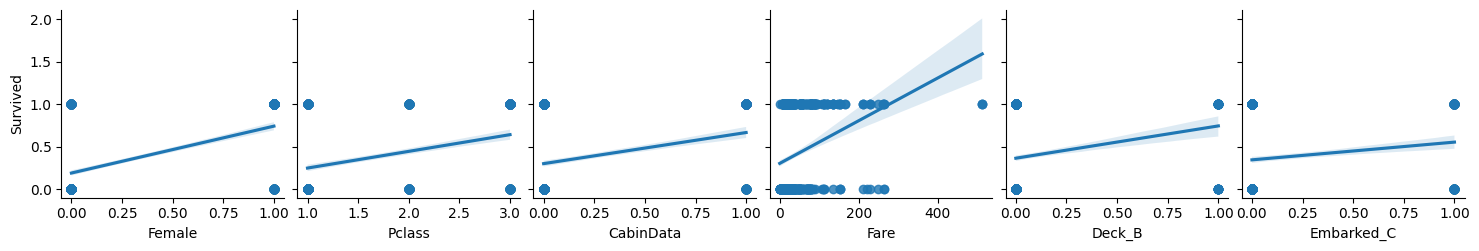

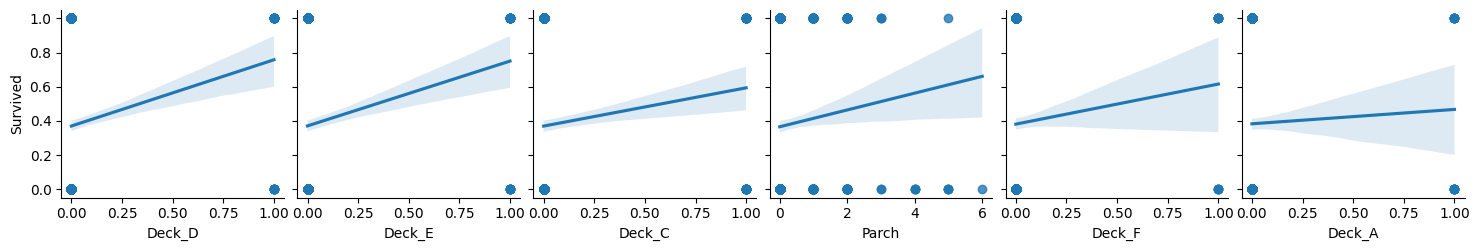

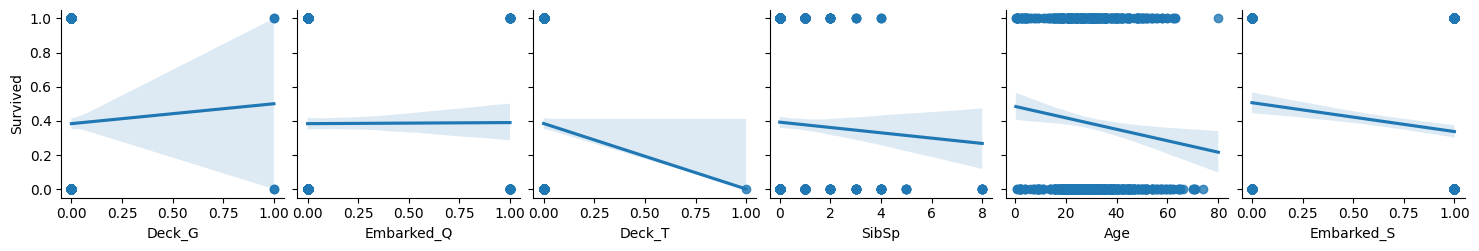

In [19]:
for i in range(0, len(survived_corr.index), 6):
    chunk = survived_corr.index[i:i+6]
    sns.pairplot(imputed_df, y_vars=['Survived'], x_vars=chunk, kind='reg')

## Model development

We begin by splitting the dataset into train and test sets and instantiate a KFold object for cross validation to avoid overfitting. Several trial and errors suggested to set the test size to 0.4, giving the best balance between cross validation score and test set accuracy score for the models.

In [20]:
# Split the data into training and test sets
model_df = imputed_df.drop(columns=['CabinData'])
X = model_df.drop(columns=['Survived'])
y = model_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# instantiate a KFold object for cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Model selection

Then we compare three classifiers and choose the best one in terms of accuracy.

Pipeline: dict_keys(['logistic']) Mean Cross-Validation Score: 0.792
Test accuracy score: 0.821


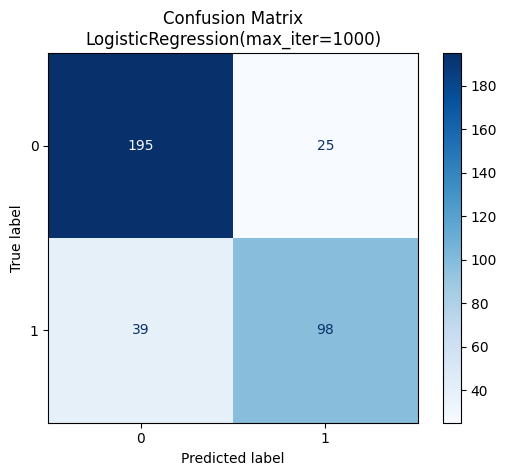

Pipeline: dict_keys(['rf']) Mean Cross-Validation Score: 0.8
Test accuracy score: 0.798


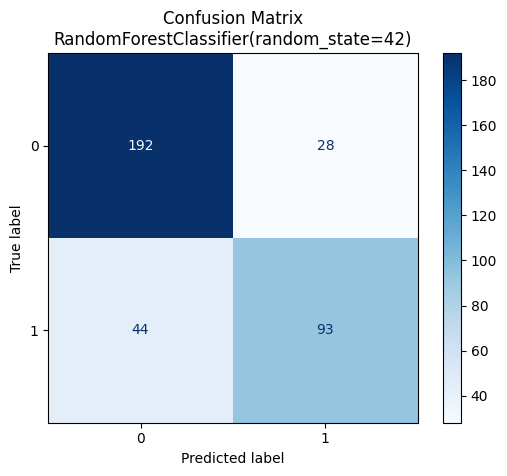

Pipeline: dict_keys(['svm']) Mean Cross-Validation Score: 0.695
Test accuracy score: 0.65


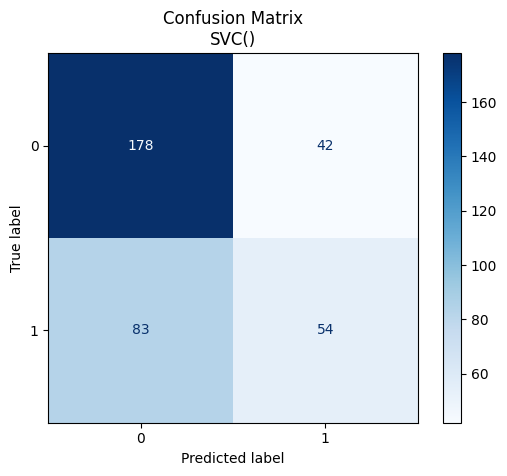

In [21]:
# Define sklearn pipelines for classifier comparison

logistic_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=1000))
])

rf_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

svm_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
    ('svm', SVC())
])

pipelines = [logistic_pipeline, rf_pipeline, svm_pipeline]
for pipeline in pipelines:
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf)
    print(f"Pipeline: {pipeline.named_steps.keys()} Mean Cross-Validation Score: {scores.mean().round(3)}")
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"Test accuracy score: {round(accuracy_score(y_pred, y_test), 3)}")
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots()
    cmd.plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(f"Confusion Matrix\n{pipeline[0]}")
    plt.show()

As we can see, the classification model with the highest accuracy score (mean cross-validation score) is the **Random Forest Classifier**. We are going to use this specific model to predict survival on the Titanic.

### Prediction with Random Forest Classifier

After having chosen the right classifier for the job, we train it on the train set with GridSearchCV, that performs an exhaustive search over a specified hyperparameter space for an estimator. It takes as input an estimator, a dictionary of hyperparameters, and a cross-validation strategy. It then fits the estimator on all possible combinations of hyperparameters and evaluates the performance of each combination using cross-validation.

The GridSearchCV class is useful for finding the best hyperparameters for a machine learning model. By testing all possible combinations of hyperparameters, it can help to identify the combination that results in the best performance on a given dataset.

Best parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
Best score: 0.8294657026979368
Test set accuracy: 0.8207282913165266


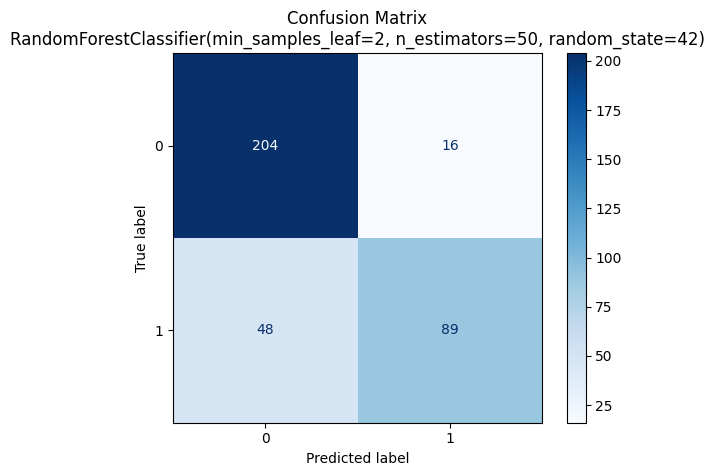

In [22]:
param_grid = {
    'rf__n_estimators': [10, 50, 100],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=kf)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
print("Test set accuracy:", grid_search.score(X_test, y_test))

estimator = grid_search.best_estimator_.named_steps['rf']

 # Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
cmd.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f"Confusion Matrix\n{estimator}")
plt.show()

We have taken the best performing algorithm and trained it on our dataset with a GridSearchCV and KFold cross validation. The perfomance on the test set suggests that the chosen classification model is able to predict Survival with an 82% of accuracy. As a final step, we are going to explain the variables which have been taken into consideration by the classifier in the prediction, and draw conclusions on the "Survived Persona".

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


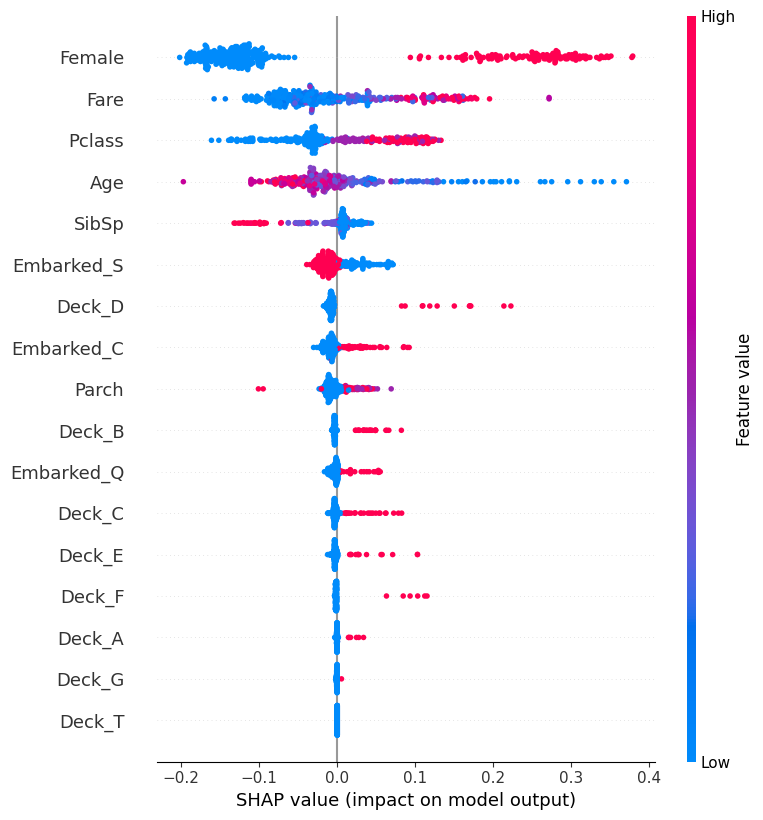

In [23]:
shap_values = shap.TreeExplainer(estimator).shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

The SHAP (SHapley Additive exPlanations) summary plot is a powerful tool for interpreting the output of a tree-based model, such as a Random Forest Classifier, using a TreeExplainer. The plot displays the features in order of their importance, as measured by their mean absolute SHAP values. Here's how to interpret the SHAP summary plot for a TreeExplainer:

* Feature importance: The features are listed along the y-axis of the plot, with the most important features at the top. The importance of each feature is represented by its mean absolute SHAP value, which is indicated by the horizontal bars.

* Impact on prediction: The color of the bars represents the direction and magnitude of the feature's impact on the model's prediction. Red bars indicate a positive impact on the prediction, while blue bars indicate a negative impact. The length of the bar represents the magnitude of the impact, with longer bars indicating a greater impact.

* Relationship between feature and prediction: The position of each bar relative to the center line indicates the direction and strength of the relationship between the feature and the prediction. Features that push the prediction towards the top of the plot are associated with higher predicted probabilities, while features that push the prediction towards the bottom are associated with lower predicted probabilities.

* Interactions between features: The spacing between the bars for each feature represents the degree of interaction between that feature and other features in the model. If the bars for two features are close together, it indicates that those features tend to interact with each other in the model.

## Conclusion

The Random Forest Classifier trained on our dataset was capable of predicting Survival on the Titanic with a 82% of accuracy. The best predictors identified by the SHAP Tree Explainer are:
* `Female`: whether the person was female or not. The red dots (representing female persons) are all gathered on the right side of the plot, meaning that they have a strong positive impact on survival.
* `Pclass`: passenger class. 1st class passengers (red dots) are located in the right size of the graph. Being a 1st class passenger would have meant sure survival.
* `Age`: older persons, represented by red dots are all gathered in the left (death) side of the plot, inversely, younger people were more prone to be saved.
* `Fare`: similar situation for fare. Higher fares (red dots) are all located in the right side, meaning that people who paid for more expensive tickets had better chances to survive.

An interesting insights that SHAP gives us is regarding the `Embarked_S`. This dummy variable tells us if the passenger was embarked in Southampton. We can see that these passengers (red dots) had practically no chance of being saved. Maybe because they were all 3rd class?

To conclude, we can say that the **Survived Persona** was a young girl, coming from the top classes (having paid a higher fare) and not embarked in Southampton.